In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
import math
import numpy as np

from datetime import datetime
import plotter
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
def build_layers(images, CONV_1, CONV_2, CONV_3, FULL_L, pkeep):
    # Layer 1
    stride = 1
    l1_weights = tf.Variable(tf.truncated_normal([6, 6, 1, CONV_1], stddev=1.0), name='l1_weights')
    l1_biases = tf.Variable(tf.ones([CONV_1])/10, name='l1_biases')
    layer_1 = tf.nn.relu(
        tf.nn.conv2d(images, l1_weights, 
                     strides=[1, stride, stride, 1], 
                     padding='SAME') + l1_biases)
    
    # Layer 2
    stride = 2
    l2_weights = tf.Variable(tf.truncated_normal([5, 5, CONV_1, CONV_2], stddev=1.0), name='l2_weights')
    l2_biases  = tf.Variable(tf.ones([CONV_2])/10, name='l2_biases')
    layer_2 = tf.nn.relu(
        tf.nn.conv2d(layer_1, l2_weights, 
                     strides=[1, stride, stride, 1], 
                     padding='SAME') + l2_biases)
    
    # Layer 3
    l3_weights = tf.Variable(tf.truncated_normal([4, 4, CONV_2, CONV_3], stddev=1.0), name='l3_weights')
    l3_biases = tf.Variable(tf.ones([CONV_3])/10, name='l3_biases')
    layer_3 = tf.nn.relu(
        tf.nn.conv2d(layer_2, l3_weights, 
                     strides=[1, stride, stride, 1], 
                     padding='SAME') + l3_biases)
    
    # Flatten all values for the fully connected layer
    reshaped_layer3 = tf.reshape(layer_3, shape=[-1, 7 * 7 * CONV_3])
    
    # Layer 4 - Fully Connected Layer
    l4_weights = tf.Variable(tf.truncated_normal([7 * 7 * CONV_3, FULL_L], stddev=1.0), name='l4_weights')
    l4_biases = tf.Variable(tf.ones([FULL_L])/10, name='l4_biases')
    layer_4 = tf.nn.relu(tf.matmul(reshaped_layer3, l4_weights) + l4_biases)
    
    l4_dropout = tf.nn.dropout(layer_4, pkeep)
    
    # Logits
    lg_weights = tf.Variable(tf.truncated_normal([FULL_L, 10], stddev=0.1), name='lg_weights')
    lg_biases = tf.Variable(tf.ones([10])/10, name='lg_biases')
    logits = tf.matmul(l4_dropout, lg_weights) + lg_biases
    
    return logits

In [4]:
def build_training_graph(logits, labels, learning_rate):
    labels = tf.to_int64(labels)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy')
    cross_entropy = tf.reduce_mean(cross_entropy, name='xentropy_mean') * 100
    
    predictions = tf.nn.softmax(logits)
    
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(cross_entropy)
    
    return train_step, cross_entropy, accuracy

In [5]:
mnist_graph = tf.Graph()

CONV_1 = 6
CONV_2 = 12
CONV_3 = 24
FULL_L = 200

with mnist_graph.as_default():
    images_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1])
    labels_placeholder = tf.placeholder(tf.float32, [None, 10])
    pkeep = tf.placeholder(tf.float32)
    
    logits = build_layers(images_placeholder,
                          CONV_1, CONV_2, CONV_3, FULL_L, pkeep)
    
    train_step, loss, accuracy = build_training_graph(logits, labels_placeholder, 0.01)
    
    init = tf.global_variables_initializer()

('2017-07-06 11:20:35', 'Step 0: loss = 201827.70')
('2017-07-06 11:20:42', 'Step 50: loss = 6195.18')
('2017-07-06 11:20:48', 'Step 100: loss = 2695.97')
('2017-07-06 11:20:53', 'Step 150: loss = 1474.09')
('2017-07-06 11:20:59', 'Step 200: loss = 1763.35')
('2017-07-06 11:21:05', 'Step 250: loss = 1102.55')
('2017-07-06 11:21:11', 'Step 300: loss = 612.94')
('2017-07-06 11:21:17', 'Step 350: loss = 355.65')
('2017-07-06 11:21:22', 'Step 400: loss = 291.20')
('2017-07-06 11:21:28', 'Step 450: loss = 281.21')
('2017-07-06 11:21:34', 'Step 500: loss = 136.29')
('2017-07-06 11:21:40', 'Step 550: loss = 180.05')
('2017-07-06 11:21:46', 'Step 600: loss = 122.46')
('2017-07-06 11:21:52', 'Step 650: loss = 124.93')
('2017-07-06 11:21:57', 'Step 700: loss = 178.26')
('2017-07-06 11:22:03', 'Step 750: loss = 124.47')
('2017-07-06 11:22:09', 'Step 800: loss = 160.04')
('2017-07-06 11:22:15', 'Step 850: loss = 58.43')
('2017-07-06 11:22:21', 'Step 900: loss = 121.45')
('2017-07-06 11:22:27', 'St

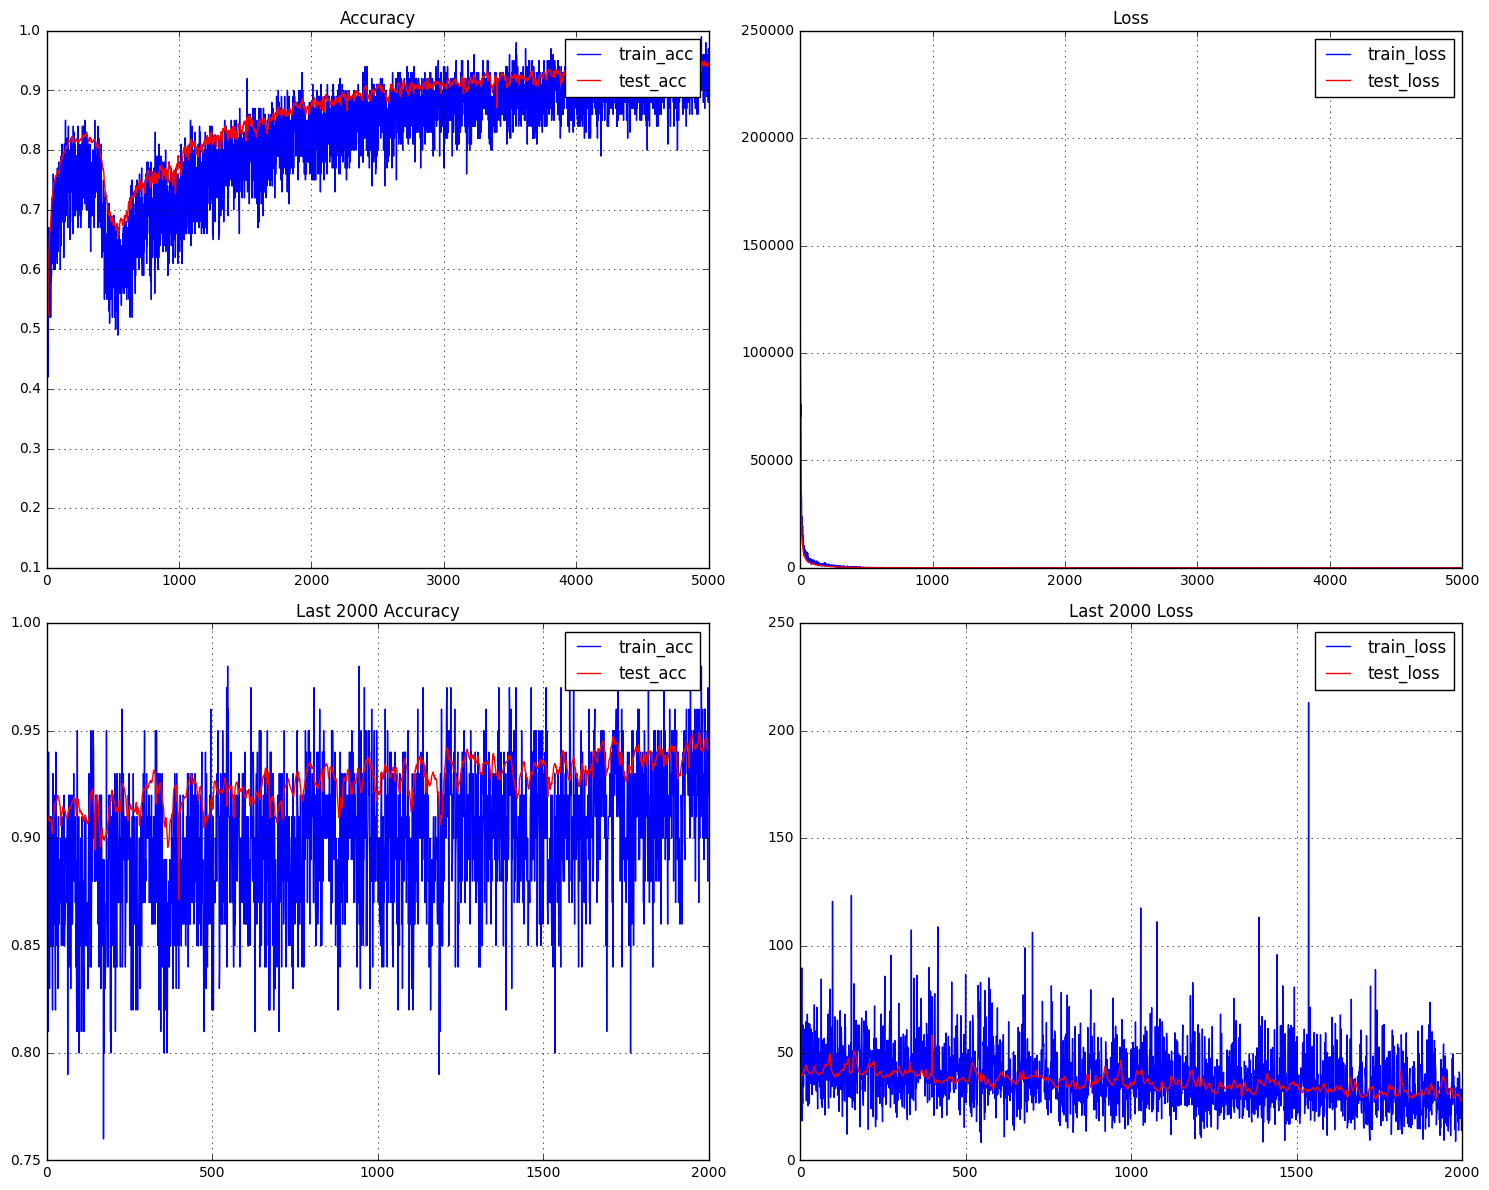

In [6]:
with tf.Session(graph=mnist_graph) as sess:
    training_acc, test_acc, test_loss, training_loss = [], [], [], []
    sess.run(init)

    test_data = {images_placeholder: mnist.test.images, 
                 labels_placeholder: mnist.test.labels,
                 pkeep: 1.0}
    
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    diff_lr = max_learning_rate - min_learning_rate
    lr_range = min_learning_rate + diff_lr
    decay_speed = 2000.0
    
    for i in range(5000):
        images_feed, labels_feed = mnist.train.next_batch(100)
        learning_rate = lr_range * math.exp(-i/decay_speed)
        
        train_data = {images_placeholder: images_feed,
                      labels_placeholder: labels_feed,
                      pkeep: 0.75}
        sess.run(train_step, feed_dict=train_data)
        
        ta, tc = sess.run([accuracy, loss], feed_dict=train_data)
        training_loss.append(tc)
        training_acc.append(ta)
        
        if (i % 50) == 0:
            print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "Step %d: loss = %.2f" % (i, tc))

        # Get accuracy and loss with test data
        a, c = sess.run([accuracy, loss], feed_dict=test_data)
        test_acc.append(a)
        test_loss.append(c)
    
    a, c = sess.run([accuracy, loss], feed_dict=test_data)
    test_acc.append(a)
    test_loss.append(c)    
    
    results = {
        'train_acc': training_acc,
        'train_loss': training_loss,
        'test_acc': test_acc, 
        'test_loss': test_loss,
    }

    print("accuracy:" + str(a) + " loss: " + str(c))
    plotter.plot_results(**results)